In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
import PIL
import os
import shutil
from sklearn.model_selection import train_test_split
from PIL import Image

from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import label_binarize

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="tensorflow_io")

In [2]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [3]:
# Paths to the datasets directories
base_dir1 = 'D:\\Detect_solar_dust'
base_dir2 = 'D:\\Detect_solar_dust'  # Add the path to your other dataset
classes = ['Clean', 'Dusty']

# Create directories for train, test, and validation if they don't exist
dir_names = ['D:\\Detect_solar_dust\\train', 'D:\\Detect_solar_dust\\test', 'D:\\Detect_solar_dust\\validate']
for dir_name in dir_names:
    if not os.path.exists(dir_name):
        os.mkdir(dir_name)

In [4]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Replace with actual base directories where your datasets are located
base_dir1 = 'D:\\Detect_solar_dust'
base_dir2 = 'D:\\Detect_solar_dust'

def process_class(class_name):
    # Ensure the directory for each class in train, test, validate exists
    for subdir in ['train', 'test', 'validate']:
        os.makedirs(os.path.join(r'D:\Detect_solar_dust', subdir, class_name), exist_ok=True)

    # Combine files from both datasets
    files1 = os.listdir(os.path.join(base_dir1, class_name))
    files2 = os.listdir(os.path.join(base_dir2, class_name))
    files = [os.path.join(base_dir1, class_name, f) for f in files1] + [os.path.join(base_dir2, class_name, f) for f in files2]
    
    # Split files into training and (test + validate) sets
    train_files, test_validate_files = train_test_split(files, test_size=0.3, random_state=42)

    # Further split the (test + validate) set into test and validate sets
    test_files, validate_files = train_test_split(test_validate_files, test_size=(1/3), random_state=42)

    # Copy files to their respective directories
    for f in train_files:
        shutil.copy(f, os.path.join(r'D:\Detect_solar_dust', 'train', class_name, os.path.basename(f)))
    for f in test_files:
        shutil.copy(f, os.path.join(r'D:\Detect_solar_dust', 'test', class_name, os.path.basename(f)))
    for f in validate_files:
        shutil.copy(f, os.path.join(r'D:\Detect_solar_dust', 'validate', class_name, os.path.basename(f)))

# Example list of classes
classes = ['Clean', 'Dusty']  # Replace with your actual list of classes

# Process each class
for class_name in classes:
    process_class(class_name)


In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

# Assuming image dimensions and batch size
image_height = 224
image_width = 224
BATCH_SIZE = 32

# Directory paths (adjust these paths according to your actual directories)
train_dir = r'D:\Detect_solar_dust\train'  # Example path for training data
test_dir = r'D:\Detect_solar_dust\test'    # Example path for test data
validate_dir = r'D:\Detect_solar_dust\validate'  # Example path for validation data

# Create data generators with rescaling
train_data_generator = ImageDataGenerator(rescale=1./255)
test_val_data_generator = ImageDataGenerator(rescale=1./255)

# Train generator
train_generator = train_data_generator.flow_from_directory(
    directory=train_dir,
    color_mode="rgb",
    target_size=(image_height, image_width),
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=1234
)

# Test generator
test_generator = test_val_data_generator.flow_from_directory(
    directory=test_dir,
    color_mode="rgb",
    target_size=(image_height, image_width),
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=1234
)

# Validation generator
validate_generator = test_val_data_generator.flow_from_directory(
    directory=validate_dir,
    color_mode="rgb",
    target_size=(image_height, image_width),
    class_mode="categorical",
    batch_size=BATCH_SIZE,
    shuffle=False,
    seed=1234
)

Found 2438 images belonging to 2 classes.
Found 1199 images belonging to 2 classes.
Found 695 images belonging to 2 classes.


In [6]:
# Get the mapping of class names to class indices
dict_class = train_generator.class_indices
print('Dictionary: {}'.format(dict_class))

# Extract the class names
class_names = list(dict_class.keys())
print('Class labels: {}'.format(class_names))

Dictionary: {'Clean': 0, 'Dusty': 1}
Class labels: ['Clean', 'Dusty']


In [7]:
# Print the dataset characteristics for the training set
print("Dataset Characteristics of Train Data Set:")
print("Number of images:", len(train_generator.classes))
for class_name, class_index in train_generator.class_indices.items():
    print(f"Number of {class_name} images:", sum(train_generator.classes == class_index))

print()  # Add a newline for better readability

# Print the dataset characteristics for the test set
print("Dataset Characteristics of Test Data Set:")
print("Number of images:", len(test_generator.classes))
for class_name, class_index in test_generator.class_indices.items():
    print(f"Number of {class_name} images:", sum(test_generator.classes == class_index))

print()  # Add a newline for better readability

# Print the dataset characteristics for the validation set
print("Dataset Characteristics of Validation Data Set:")
print("Number of images:", len(validate_generator.classes))
for class_name, class_index in validate_generator.class_indices.items():
    print(f"Number of {class_name} images:", sum(validate_generator.classes == class_index))

print()  # Add a newline for better readability

Dataset Characteristics of Train Data Set:
Number of images: 2438
Number of Clean images: 1466
Number of Dusty images: 972

Dataset Characteristics of Test Data Set:
Number of images: 1199
Number of Clean images: 817
Number of Dusty images: 382

Dataset Characteristics of Validation Data Set:
Number of images: 695
Number of Clean images: 494
Number of Dusty images: 201



Train image data from Data Augmentation 1 *Preprocessing*


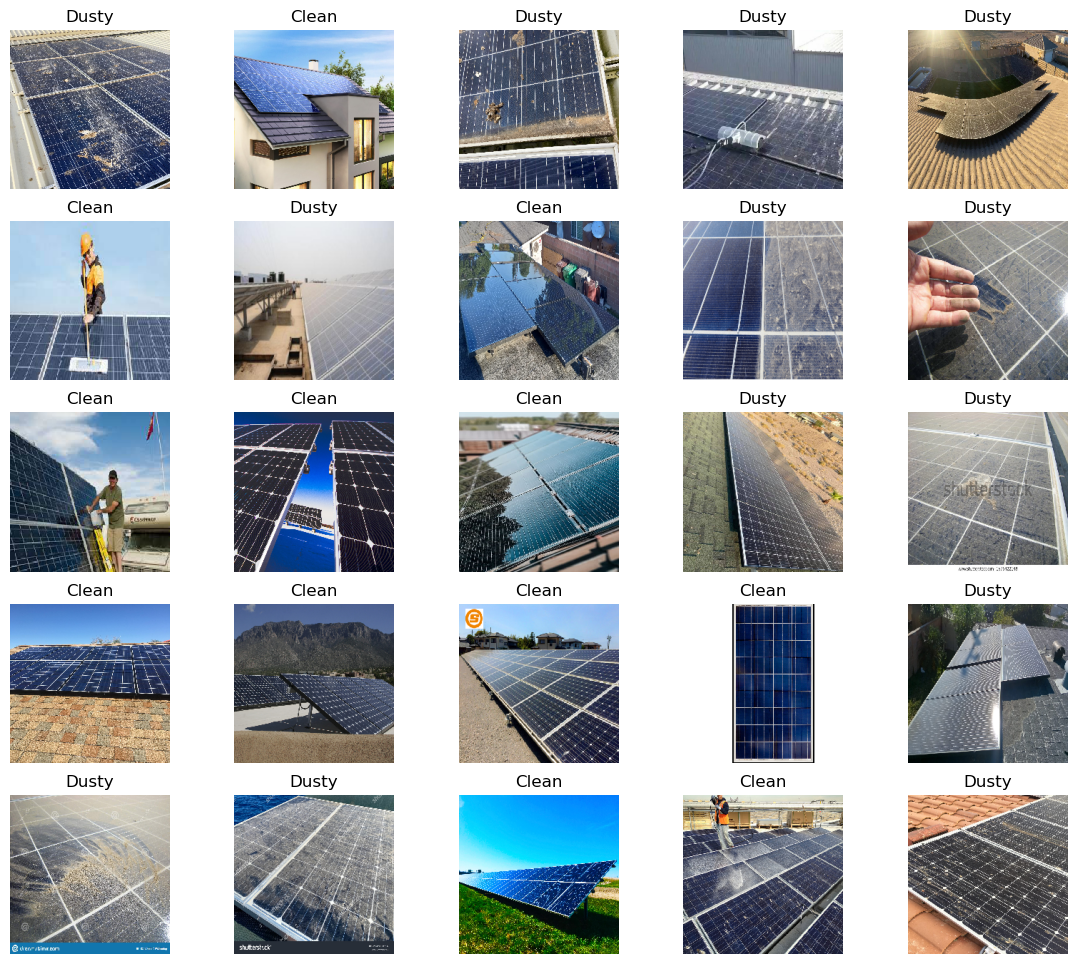

In [8]:
# Image Samples
print('Train image data from Data Augmentation 1 *Preprocessing*')
img, label = next(train_generator)

plt.figure(figsize=[14, 12])
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(img[i])
    plt.axis('off')
    plt.title(class_names[np.argmax(label[i])])    
plt.show()

In [9]:
# Initialize VGG16 model with pre-trained weights on ImageNet,
# excluding the fully connected layers for feature extraction.
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_height, image_width, 3))

In [10]:
base_model.trainable = False

In [11]:
# Add custom layers
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(class_names), activation='sigmoid')) 

In [12]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
# Compute Class Weights
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(train_generator.classes), y= train_generator.classes)
class_weights = dict(zip(np.unique(train_generator.classes), class_weights))
class_weights

{0: 0.8315143246930423, 1: 1.2541152263374487}

In [14]:
epoch = 50
# Train the model using the training generator, validating on the validation generator,
# specifying the number of epochs, and incorporating class weights for imbalanced datasets.
history = model.fit(train_generator, validation_data=validate_generator, epochs=epoch, class_weight=class_weights)

Epoch 1/50


C:\Users\kanak\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


10/77 ━━━━━━━━━━━━━━━━━━━━ 3:11 3s/step - accuracy: 0.4911 - loss: 1.6642

C:\ProgramData\anaconda3\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


77/77 ━━━━━━━━━━━━━━━━━━━━ 377s 5s/step - accuracy: 0.5899 - loss: 1.0632 - val_accuracy: 0.7827 - val_loss: 0.5025
Epoch 2/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 403s 5s/step - accuracy: 0.7121 - loss: 0.5301 - val_accuracy: 0.7669 - val_loss: 0.4974
Epoch 3/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 393s 5s/step - accuracy: 0.7657 - loss: 0.4647 - val_accuracy: 0.7856 - val_loss: 0.4684
Epoch 4/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 20201s 5s/step - accuracy: 0.7966 - loss: 0.4330 - val_accuracy: 0.8475 - val_loss: 0.3921
Epoch 5/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 398s 5s/step - accuracy: 0.8175 - loss: 0.4171 - val_accuracy: 0.8705 - val_loss: 0.3481
Epoch 6/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 394s 5s/step - accuracy: 0.8172 - loss: 0.3926 - val_accuracy: 0.8993 - val_loss: 0.2814
Epoch 7/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 392s 5s/step - accuracy: 0.8507 - loss: 0.3246 - val_accuracy: 0.8835 - val_loss: 0.2802
Epoch 8/50
77/77 ━━━━━━━━━━━━━━━━━━━━ 392s 5s/step - accuracy: 0.8717 - loss: 0.2880 - val_accuracy: 0.8878 - val_loss: 

In [15]:
# Evaluate the model on the test datawith class weights
evaluation = model.evaluate(test_generator)

# The evaluation result is a list containing the loss and any metrics you specified during model compilation
loss, accuracy = evaluation

print("Evaluation Results:")
print("Test Loss: {:.4f}".format(loss))
print("Test Accuracy: {:.2%}".format(accuracy))

38/38 ━━━━━━━━━━━━━━━━━━━━ 135s 4s/step - accuracy: 0.9762 - loss: 0.0552
Evaluation Results:
Test Loss: 0.1154
Test Accuracy: 97.00%


In [25]:
# Evaluate the model on the training data
training_evaluation = model.evaluate(train_generator)

# The evaluation result is a list containing the loss and any metrics you specified during model compilation
train_loss, train_accuracy = training_evaluation

print("Training Results:")
print("Train Loss: {:.4f}".format(train_loss))
print("Train Accuracy: {:.2%}".format(train_accuracy))


 2/77 ━━━━━━━━━━━━━━━━━━━━ 3:53 3s/step - accuracy: 1.0000 - loss: 8.5503e-04

C:\ProgramData\anaconda3\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


77/77 ━━━━━━━━━━━━━━━━━━━━ 266s 3s/step - accuracy: 0.9932 - loss: 0.0174
Training Results:
Train Loss: 0.0233
Train Accuracy: 98.89%


In [27]:
# Evaluate the model on the validation data
validation_evaluation = model.evaluate(validate_generator)

# The evaluation result is a list containing the loss and any metrics you specified during model compilation
val_loss, val_accuracy = validation_evaluation

print("Validation Results:")
print("Validation Loss: {:.4f}".format(val_loss))
print("Validation Accuracy: {:.2%}".format(val_accuracy))


22/22 ━━━━━━━━━━━━━━━━━━━━ 69s 3s/step - accuracy: 0.9681 - loss: 0.1096
Validation Results:
Validation Loss: 0.2430
Validation Accuracy: 95.97%


In [16]:
# Obtain true labels and predictions during testing
true_labels = []
predictions = []

# Reset the test generator to the beginning
test_generator.reset()

# Loop through the test generator to accumulate true labels and predictions
for i in range(len(test_generator)):
    images, labels = next(test_generator)
    true_labels.extend(labels)
    predictions_batch = model.predict(images)
    predictions.extend(predictions_batch)

# Convert lists to NumPy arrays
true_labels = np.concatenate(true_labels)
predictions = np.concatenate(predictions)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


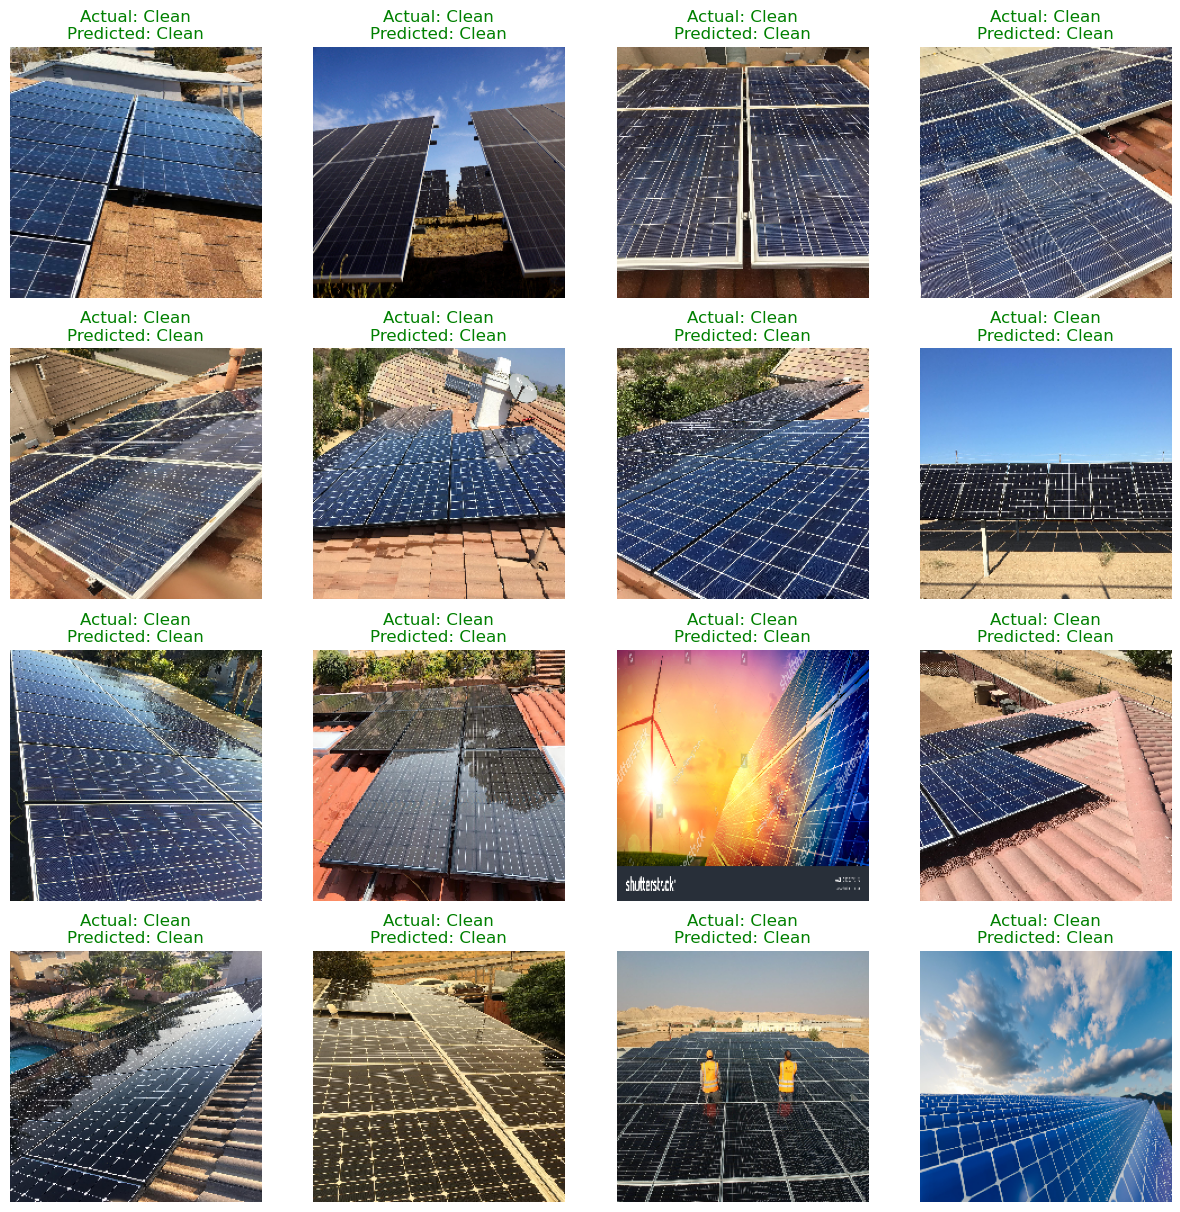

In [17]:
# Visualize a sample of images with true and predicted labels
num_samples = 16  # Change this based on how many samples you want to visualize

# Reset the test generator to the beginning
test_generator.reset()

# Obtain a batch of images and labels from the test generator
images, true_labels = next(test_generator)

# Predictions for the batch
predictions_batch = model.predict(images)

# Convert the batch predictions and true labels to NumPy arrays
predictions = np.argmax(predictions_batch, axis=1)
true_labels = np.argmax(true_labels, axis=1)

# Rescale pixel values to the range [0, 255]
images = (images * 255).astype("uint8")

# Visualize a sample of images with true and predicted labels
plt.figure(figsize=(15, 15))
for i in range(min(num_samples, len(true_labels))):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i]) 
     
    if class_names[true_labels[i]] == class_names[predictions[i]]:
        title_color = 'green'
    else:
        title_color = 'red'
    
    plt.title("Actual: {}\nPredicted: {}".format(class_names[true_labels[i]], class_names[predictions[i]]), color=title_color)
    plt.axis("off")

plt.show()

In [18]:
model.save('my_trained_vgg16_model.keras')

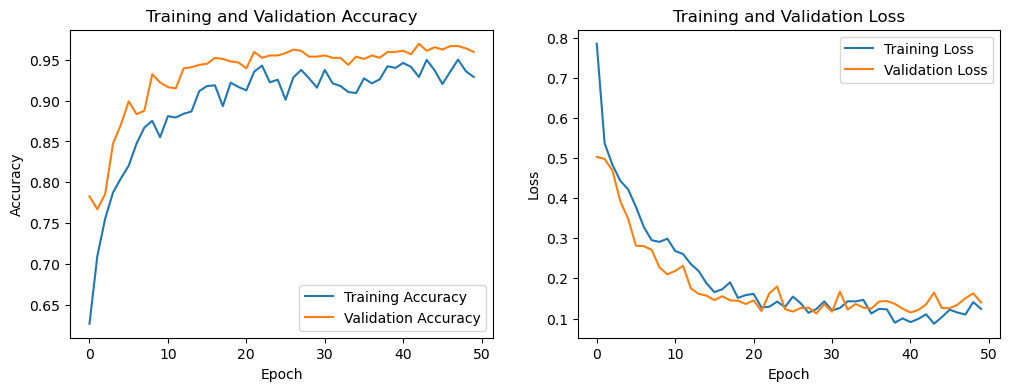

In [19]:
# Extract training and validation loss and accuracy from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

# Plot the training and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot the training and validation accuracy
plt.subplot(1, 2, 1)
plt.plot(train_accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()



In [20]:

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,137,986 (80.64 MB)

 Trainable params: 6,423,298 (24.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 

<Figure size 800x600 with 0 Axes>

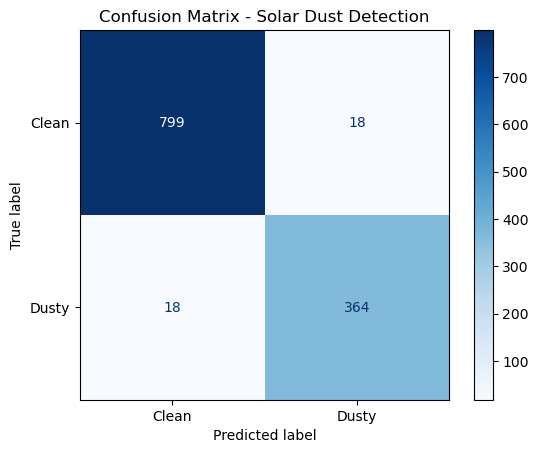

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Assuming true_labels and predictions are obtained from the model predictions
true_labels = []
predictions = []

# Reset the test generator to the beginning
test_generator.reset()

# Loop through the test generator to accumulate true labels and predictions
for _ in range(len(test_generator)):
    images, labels = next(test_generator)
    true_labels.extend(np.argmax(labels, axis=1))  # Convert one-hot to class indices
    predictions_batch = model.predict(images)
    predictions.extend(np.argmax(predictions_batch, axis=1))  # Get predicted class indices

# Convert lists to NumPy arrays
true_labels = np.array(true_labels)
predictions = np.array(predictions)

# Create a confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(test_generator.class_indices.keys()))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Solar Dust Detection')
plt.show()


In [22]:
import numpy as np
from sklearn.metrics import classification_report

# Assuming true_labels and predictions are obtained from the model predictions
true_labels = []
predictions = []

# Reset the test generator to the beginning
test_generator.reset()

# Loop through the test generator to accumulate true labels and predictions
for _ in range(len(test_generator)):
    images, labels = next(test_generator)
    true_labels.extend(np.argmax(labels, axis=1))  # Convert one-hot to class indices
    predictions_batch = model.predict(images)
    predictions.extend(np.argmax(predictions_batch, axis=1))  # Get predicted class indices

# Convert lists to NumPy arrays
true_labels = np.array(true_labels)
predictions = np.array(predictions)

# Get the class names from the test generator
class_names = list(test_generator.class_indices.keys())

# Generate the classification report
report = classification_report(true_labels, predictions, target_names=class_names)

# Print the classification report
print("Classification Report:")
print(report)


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


C:\ProgramData\anaconda3\Lib\site-packages\PIL\Image.py:1000: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 

In [23]:
model.save('my_trained_vgg16_model.keras')

pygame 2.6.0 (SDL 2.28.4, Python 3.12.4)
Hello from the pygame community. https://www.pygame.org/contribute.html
Dusty sound file found: C:\Users\kanak\Downloads\beepwarning.mp3


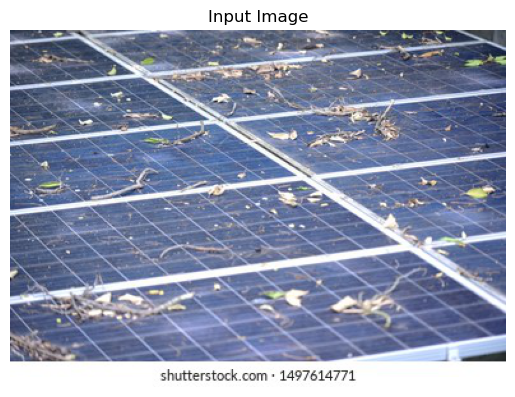

C:\Users\kanak\AppData\Roaming\Python\Python312\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 10 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step
The solar panel is predicted to be: Dusty


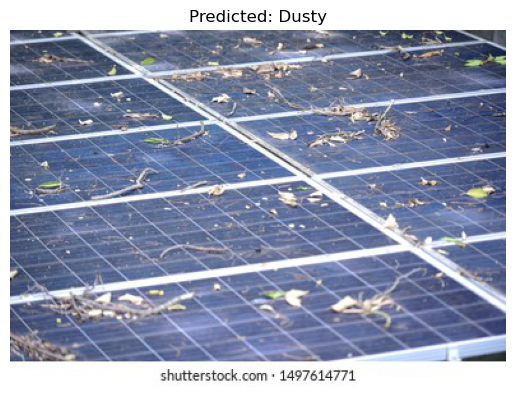

Please clean! To save the resource...


In [24]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pyttsx3  # Text-to-speech module
import os  # File path validation
import pygame  # Sound playback
import threading  # For concurrency
from IPython.display import display, HTML  # For displaying HTML in Jupyter

# Initialize text-to-speech and pygame mixer
engine = pyttsx3.init()
pygame.mixer.init()

# Function to preprocess the input image
def preprocess_image(image_path, target_size):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array /= 255.0  # Rescale the image
    return img_array

# Function to load and display the image
def load_and_display_image(img_path):
    img = Image.open(img_path)
    plt.imshow(img)
    plt.axis('off')  # Hide axis
    plt.title('Input Image')
    plt.show()
    return img

# Function to display a flashing danger-style message in Jupyter
def display_flashing_danger_message(message):
    html_message = f"""
    <style>
        @keyframes blink {{
            0%, 100% {{ color: white; }}
            50% {{ color: darkred; }}
        }}
        .flashing {{
            animation: blink 1s infinite;
            font-size: 24px;  /* Adjust font size if needed */
            font-weight: bold; /* Make text bold */
            padding: 20px;
            border-radius: 5px;
            background-color: red;  /* Set the background color to red */
        }}
    </style>
    <div class="flashing">
        <h2>⚠️ Danger Alert</h2>
        <p style="color: white;">{message}</p>
    </div>
    """
    display(HTML(html_message))

# Function to play sound
def play_sound(sound_file):
    try:
        # Load and play the sound
        pygame.mixer.music.load(sound_file)
        pygame.mixer.music.play(loops=3)  # Play the sound 3 times (initial + 2 loops)

        print("Please clean! To save the resource...")

        # Wait for the sound to finish playing
        while pygame.mixer.music.get_busy():
            pygame.time.Clock().tick(10)

    except Exception as e:
        print(f"Error playing dusty sound: {e}")

# Path to the image and sound file
image_path = r"D:\Detect_solar_dust\Dusty\Imgdirty_13_1.jpg"
dusty_sound_file = r'C:\Users\kanak\Downloads\beepwarning.mp3'
input_shape = (224, 224)

# Check if the sound file exists
if not os.path.exists(dusty_sound_file):
    print(f"Dusty sound file not found: {dusty_sound_file}")
else:
    print(f"Dusty sound file found: {dusty_sound_file}")

# Load and display the image
displayed_image = load_and_display_image(image_path)

# Preprocess the image
image = preprocess_image(image_path, input_shape)

# Load your trained model
model = load_model(r"C:\Users\kanak\Downloads\my_trained_vgg16_model.keras")

# Predict the class of the image
prediction = model.predict(image)

# Decode the prediction
class_names = ['Clean', 'Dusty']
predicted_class = class_names[np.argmax(prediction)]

# Print and speak the prediction
prediction_message = f'The solar panel is predicted to be: {predicted_class}'
print(prediction_message)
engine.say(prediction_message)  # Speak the prediction
engine.runAndWait()  # Wait until the speech is finished

# Display the prediction along with the image
plt.imshow(displayed_image)
plt.axis('off')
plt.title(f'Predicted: {predicted_class}')
plt.show()

# Notify user and play sound based on prediction
if predicted_class == 'Dusty':
    alert_message = "The solar panel is dusty."

    # Display the flashing danger-style message in Jupyter Notebook
    display_flashing_danger_message(alert_message)

    # Create and start thread for playing sound
    sound_thread = threading.Thread(target=play_sound, args=(dusty_sound_file,))
    sound_thread.start()  # Start playing sound

    # Wait for the sound thread to finish
    sound_thread.join()

else:
    clean_message = "The solar panel is clean. Your energy is preserved!"
    print(clean_message)
    engine.say(clean_message)  # Speak the clean message
    engine.runAndWait()  # Wait until the speech is finished
    display(HTML(f"<h2 style='color:green;'>{clean_message}</h2>"))  # Display the clean message in green
